# <font color='ForestGreen'>Implementing a NN from scratch - [WildML]</font>

In this post, we will implement a simple 3-layer neural network from scratch.

In [0]:
# Package imports
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

## <font color='Indianred'>Generating a dataset</font>

Let us start by generating a dataset we can play with. Fortunately, `scikit-learn` has some useful dataset generators, so we don't need to write the code ourselves. We will go with the [`make_moons`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function.

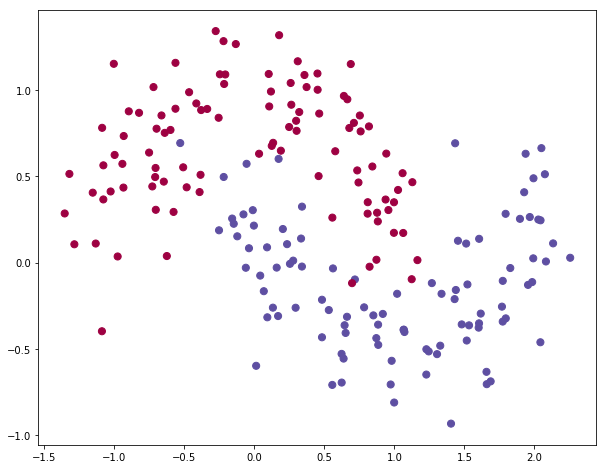

In [0]:
# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=50, c=y, cmap=plt.cm.Spectral)

The dataset we generated has two classes, plotted as red and blue points. You can think of the blue dots as male patients and the red dots as female patients, with the x- and y- axis being some measurements. 

Our goal is to train a ML classifier that predicts the correct class (male or female) given the x- and y- coordinates. Note that the data is not *linearly separable*, we can't draw a straight line that separates the two classes. This means that linear classifiers, such as Logistic Regression, won't be able to fit the data unless you hand-engineer non-linear features (such as polynomials) that work well for the given dataset.

In fact, that's one of the major advantages of Neural Networks. You don't need to worry about feature engineering. The hidden layer of a neural network will learn features for you.

## <font color='Indianred'>Logistic Regression</font>

To demonstrate the point let's train a Logistic Regression classifier. It's input will be the x- and y-values and the output the predicted class (0/1). To make our life easy we use the Logistic Regression class from `scikit-learn`.

In [0]:
# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV(cv=5)
clf.fit(X, y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

In [0]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry, it just generates the contour plot below.

def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

Text(0.5,1,'Logistic Regression')

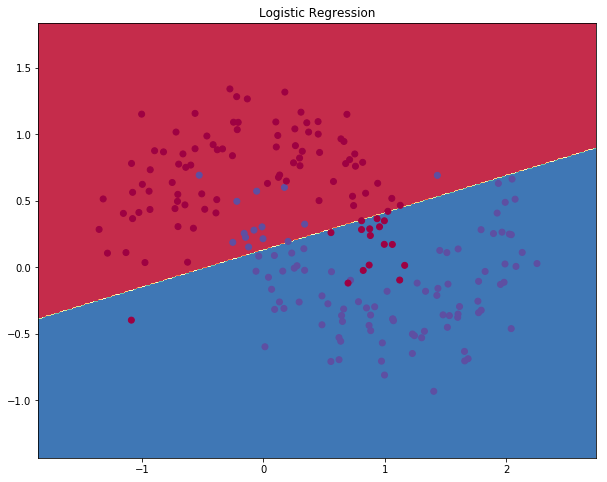

In [0]:
# Plot the decision boundary
plot_decision_boundary(lambda x: clf.predict(x))
plt.title("Logistic Regression")

The graph shows the decision boundary learned by our Logistic Regression classifier. It separates the data as good as it can using a straight line, but it is unable to capture the "moon shape" of our data.



## <font color='Indianred'>Training a Neural Network</font>

Let's now build a 3-layer neural network with **one input layer, one hidden layer, and one output layer**. 
- The number of nodes in the input layer is determined by the dimensionality of our data i.e 2 (the x, y coordinates here). 
- The number of nodes in the output layer is determined by the number of classes we have, also 2 (blue or red). (Because we only have 2 classes we could actually get away with only one output node predicting 0 or 1, but having 2 makes it easier to extend the network to more classes later on). 

The input to the network will be x- and y- coordinates and its output will be two probabilities, one for class 0 (`female`) and one for class 1 (`male`).

We can choose the dimensionality (the number of nodes) of the hidden layer. 
 - The more nodes we put into the hidden layer the more complex functions we will be able fit. But higher dimensionality comes at a cost. First, more computation is required to make predictions and learn the network parameters. A bigger number of parameters also means we become more prone to overfitting our data. 

We will play with the number of nodes in the hidden layer later on and see how it affects our output.

We also need to pick an *activation function* for our hidden layer. 
- The activation function transforms the inputs of the layer into its final outputs. A nonlinear activation function is what allows us to fit nonlinear hypotheses. 
- Common chocies for activation functions are [tanh](https://reference.wolfram.com/language/ref/Tanh.html), the [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function), or [ReLUs](https://en.wikipedia.org/wiki/Rectifier_(neural_networks). 
-We will use `tanh`, which performs quite well in many scenarios. A nice property of these functions is that their derivate can be computed using the original function value. For example, the derivative of $\tanh x$ is $1-\tanh^2 x$. This is useful because it allows us to compute $\tanh x$ once and re-use its value later on to get the derivative.

We want our network to output probabilities 
- the activation function for the output layer will be the [softmax](https://en.wikipedia.org/wiki/Softmax_function), which is simply a way to convert raw scores to probabilities. 
- If you're familiar with the logistic function you can think of softmax as its generalization to multiple classes.

### <font color='Indianred'>How our network makes predictions</font>

Our network makes predictions using *forward propagation*, which is just a bunch of matrix multiplications and the application of the activation function(s) we defined above. If $x$ is the 2-dimensional input to our network then we calculate our prediction $\hat{y}$ (also two-dimensional) as follows:

$$
\begin{aligned}
z_1 & = W_1x + b_1 \\
a_1 & = \tanh(z_1) \\
z_2 & = W_2a_1 + b_2 \\
a_2 & = \hat{y} = \mathrm{softmax}(z_2)
\end{aligned}
$$

$z_i$ is the weighted sum of inputs of layer $i$ (bias included) and $a_i$ is the output of layer $i$ after applying the activation function. $W_1, b_1, W_2, b_2$ are  parameters of our network, which we need to learn from our training data. You can think of them as matrices transforming data between layers of the network. Looking at the matrix multiplications above we can figure out the dimensionality of these matrices. If we use 50 nodes for our hidden layer then $W_1 \in \mathbb{R}^{50\times2}$, $b_1 \in \mathbb{R}^{50}$, $W_2 \in \mathbb{R}^{2\times50}$, $b_2 \in \mathbb{R}^{2}$. Now you see why we have more parameters if we increase the size of the hidden layer.

### <font color='Indianred'>Learning the Parameters</font>

Learning the parameters means finding parameters ($W_1, b_1, W_2, b_2$) that minimize the error on our training data. But how do we define the error? We call the function that measures our error the *loss function*. A common choice with the softmax output is the `cross-entropy` loss. If we have $N$ training examples and $C$ classes then the loss for our prediction $\hat{y}$ with respect to the true labels $y$ is given by:

$$
\begin{aligned}
L(y,\hat{y}) = - \frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i} \log\hat{y}_{n,i}
\end{aligned}
$$



The formula looks complicated, but all it really does is sum over our training examples and add to the loss if we predicted the incorrect class. So, the further away $y$ (the correct labels) and $\hat{y}$ (our predictions) are, the greater our loss will be. 

Remember that our goal is to find the parameters that minimize our loss function. We can use [gradient descent](http://cs231n.github.io/optimization-1/) to find its minimum. I will implement the most vanilla version of gradient descent, also called batch gradient descent with a fixed learning rate. Variations such as SGD (stochastic gradient descent) or minibatch gradient descent typically perform better in practice. So if you are serious you'll want to use one of these, and ideally you would also [decay the learning rate over time](http://cs231n.github.io/neural-networks-3/#anneal).

For input, gradient descent needs the gradients (vector of derivatives) of the loss function with respect to our parameters: $\frac{\partial{L}}{\partial{W_1}}$, $\frac{\partial{L}}{\partial{b_1}}$, $\frac{\partial{L}}{\partial{W_2}}$, $\frac{\partial{L}}{\partial{b_2}}$. To calculate these gradients we use the *backpropagation algorithm*, which is a way to efficiently calculate the gradients starting from the output. 

**Source**: 
1. [Chris Olah - Backprop ](http://colah.github.io/posts/2015-08-Backprop/)
2. [CS 231](http://cs231n.github.io/optimization-2/)

$$
\begin{aligned}
& \delta_3 = \hat{y} - y \\
& \delta_2 = (1 - \tanh^2z_1) \circ \delta_3W_2^T \\
& \frac{\partial{L}}{\partial{W_2}} = a_1^T \delta_3  \\
& \frac{\partial{L}}{\partial{b_2}} = \delta_3\\
& \frac{\partial{L}}{\partial{W_1}} = x^T \delta_2\\
& \frac{\partial{L}}{\partial{b_1}} = \delta_2 \\
\end{aligned}
$$

## <font color='Indianred'>Implementation</font>

In [0]:
num_examples = len(X)  # training set size
nn_input_dim = 2       # input layer dimensionality
nn_output_dim = 2      # output layer dimensionality

# Gradient descent parameter
epsilon = 0.01    # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength

First let's implement the loss function we defined above. We use this to evaluate how well our model is doing:

In [0]:
# Helper function to evaluate the total loss on the dataset
def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

We also implement a helper function to calculate the output of the network. It does forward propagation as defined above and returns the class with the highest probability.

In [0]:
# Helper function to predict an output (0 or 1)
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

Finally, here comes the function to train our Neural Network. It implements batch gradient descent using the backpropagation derivates we found above.

In [0]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(nn_hdim, num_passes=10000, print_loss=False):
    
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = {}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # Backpropagation
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1

        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
          print("Loss after iteration %i: %f" %(i, calculate_loss(model)))
    
    return model

### A network with a hidden layer of size 3

Let's see what happens if we train a network with a hidden layer size of 3.


Loss after iteration 0: 0.432387
Loss after iteration 1000: 0.068947
Loss after iteration 2000: 0.068888
Loss after iteration 3000: 0.070752
Loss after iteration 4000: 0.070748
Loss after iteration 5000: 0.070751
Loss after iteration 6000: 0.070754
Loss after iteration 7000: 0.070756
Loss after iteration 8000: 0.070757
Loss after iteration 9000: 0.070758


Text(0.5,1,'Decision Boundary for hidden layer size 3')

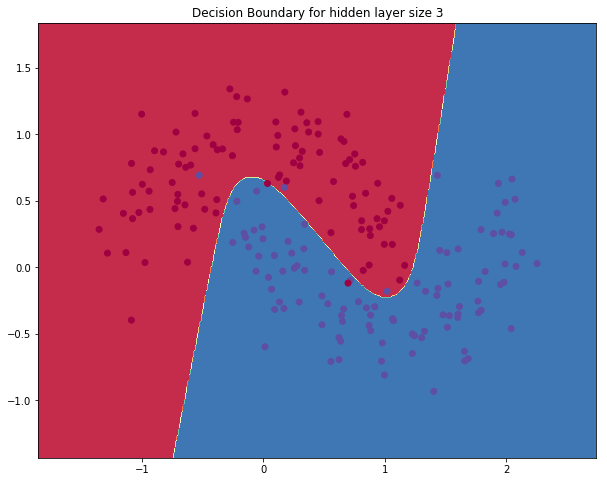

In [0]:
# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

# <font color='Indianred'>Varying the hidden layer size</font>

In the example above we picked a hidden layer size of 3. Let's now get a sense of how varying the hidden layer size affects the result.


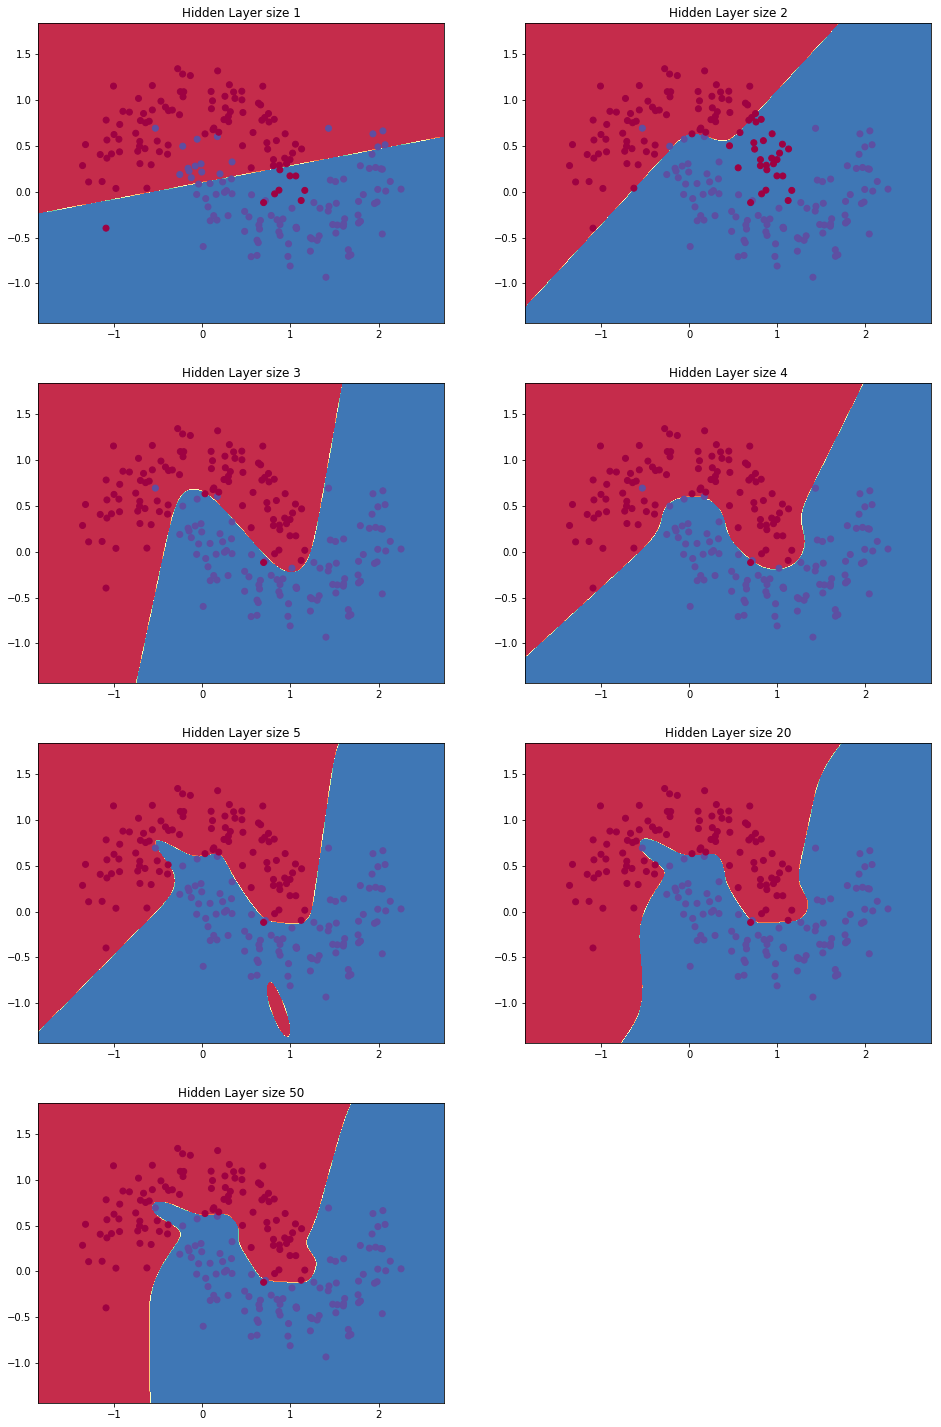

In [0]:
plt.figure(figsize=(16, 32))
hidden_layer_dimensions = [1, 2, 3, 4, 5, 20, 50]
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % nn_hdim)
    model = build_model(nn_hdim)
    plot_decision_boundary(lambda x: predict(model, x))
plt.show()

We can see that while a hidden layer of low dimensionality nicely capture the general trend of our data, but higher dimensionalities are prone to overfitting. They are "memorizing" the data as opposed to fitting the general shape. If we were to evaluate our model on a separate test set (and you should!) the model with a smaller hidden layer size would likely perform better because it generalizes better. We could counteract overfitting with stronger regularization, but picking the correct size for hidden layer is a much more "economical" solution.

# Exercises

Here are some things you can try to become more familiar with the code:

1. Instead of batch gradient descent, use minibatch gradient descent ([more info](http://cs231n.github.io/optimization-1/#gd)) to train the network. Minibatch gradient descent typically performs better in practice. 
2. We used a fixed learning rate $\epsilon$ for gradient descent. Implement an annealing schedule for the gradient descent learning rate ([more info](http://cs231n.github.io/neural-networks-3/#anneal)). 
3. We used a $\tanh$ activation function for our hidden layer. Experiment with other activation functions (some are mentioned above). Note that changing the activation function also means changing the backpropagation derivative.
4. Extend the network from two to three classes. You will need to generate an appropriate dataset for this.
5. Extend the network to four layers. Experiment with the layer size. Adding another hidden layer means you will need to adjust both the forward propagation as well as the backpropagation code.
